In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/seattle-weather.csv')

# Quick peek
print(df.head())
print(f"\nDataset shape: {df.shape}")
print(df.info())

         date  precipitation  temp_max  temp_min  wind  weather
0  2012-01-01            0.0      12.8       5.0   4.7  drizzle
1  2012-01-02           10.9      10.6       2.8   4.5     rain
2  2012-01-03            0.8      11.7       7.2   2.3     rain
3  2012-01-04           20.3      12.2       5.6   4.7     rain
4  2012-01-05            1.3       8.9       2.8   6.1     rain

Dataset shape: (1461, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB
None


In [4]:
# Convert date to datetime and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# Add average temperature
df['temp_avg'] = (df['temp_max'] + df['temp_min']) / 2

# Check for missing values and duplicates
print("Missing values:\n", df.isnull().sum())
print(f"\nDuplicates: {df.duplicated().sum()}")

# Drop any if present (unlikely)
df = df.drop_duplicates()

print("\nFirst few rows after preprocessing:")
print(df.head())

Missing values:
 precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
temp_avg         0
dtype: int64

Duplicates: 8

First few rows after preprocessing:
            precipitation  temp_max  temp_min  wind  weather  temp_avg
date                                                                  
2012-01-01            0.0      12.8       5.0   4.7  drizzle      8.90
2012-01-02           10.9      10.6       2.8   4.5     rain      6.70
2012-01-03            0.8      11.7       7.2   2.3     rain      9.45
2012-01-04           20.3      12.2       5.6   4.7     rain      8.90
2012-01-05            1.3       8.9       2.8   6.1     rain      5.85


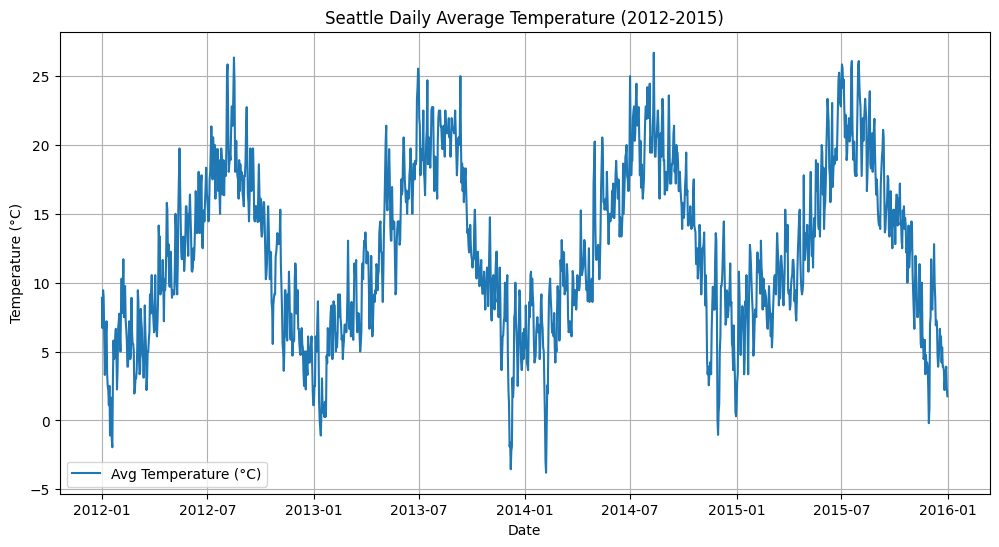

ADF Statistic: -2.3229
p-value: 0.1647
Series is non-stationary (may need differencing).


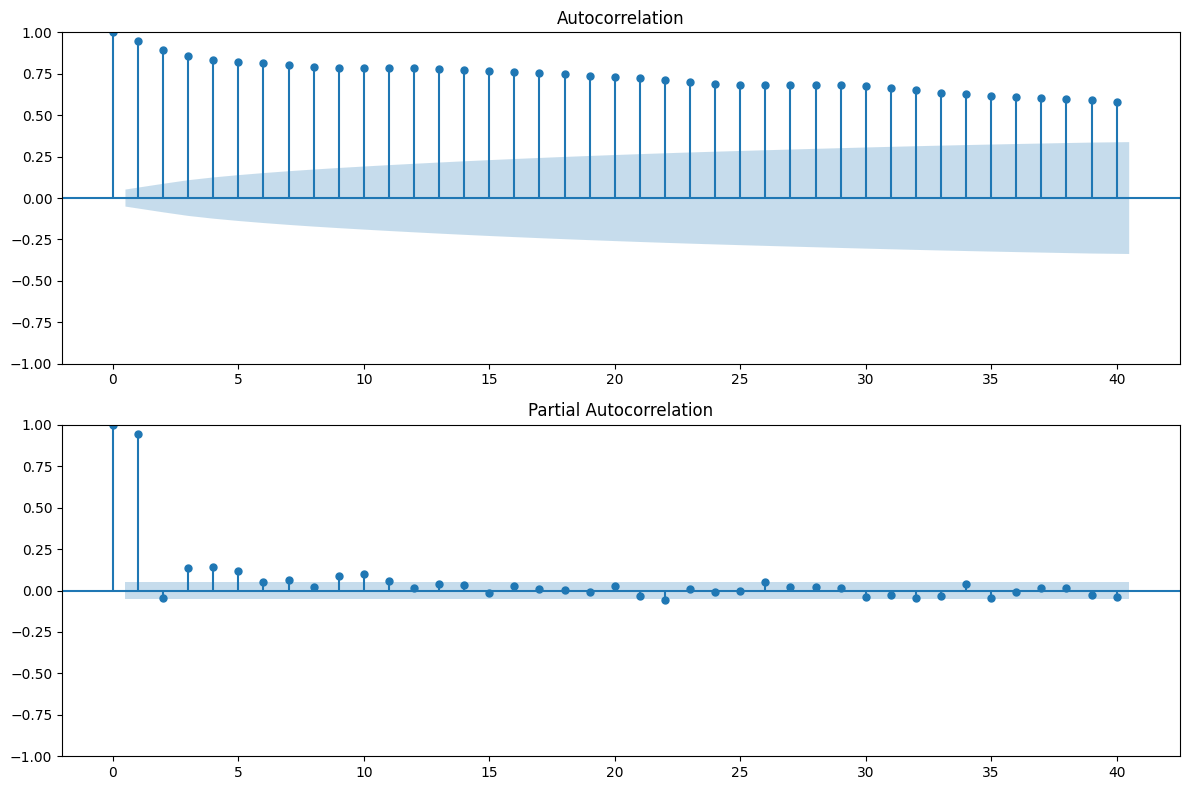

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['temp_avg'], label='Avg Temperature (°C)')
plt.title('Seattle Daily Average Temperature (2012-2015)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

# Check stationarity with ADF test
adf_result = adfuller(df['temp_avg'])
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
if adf_result[1] > 0.05:
    print("Series is non-stationary (may need differencing).")
else:
    print("Series is stationary.")

# ACF and PACF plots for ARIMA parameter selection
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['temp_avg'], ax=ax1, lags=40)
plot_pacf(df['temp_avg'], ax=ax2, lags=40)
plt.tight_layout()
plt.show()

In [6]:
# Split data (last 20% for testing)
train_size = int(len(df) * 0.8)
train = df['temp_avg'][:train_size]
test = df['temp_avg'][train_size:]

print(f"Train size: {len(train)}, Test size: {len(test)}")

# Fit ARIMA model (p=1, d=1, q=1)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Summary of model
print(model_fit.summary())

Train size: 1162, Test size: 291
                               SARIMAX Results                                
Dep. Variable:               temp_avg   No. Observations:                 1162
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2363.037
Date:                Tue, 30 Sep 2025   AIC                           4732.075
Time:                        13:14:55   BIC                           4747.246
Sample:                             0   HQIC                          4737.799
                               - 1162                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7356      0.037     19.781      0.000       0.663       0.808
ma.L1         -0.9145      0.023    -40.051      0.000      -0.959      -0.870
sigma2         3.42

RMSE: nan°C


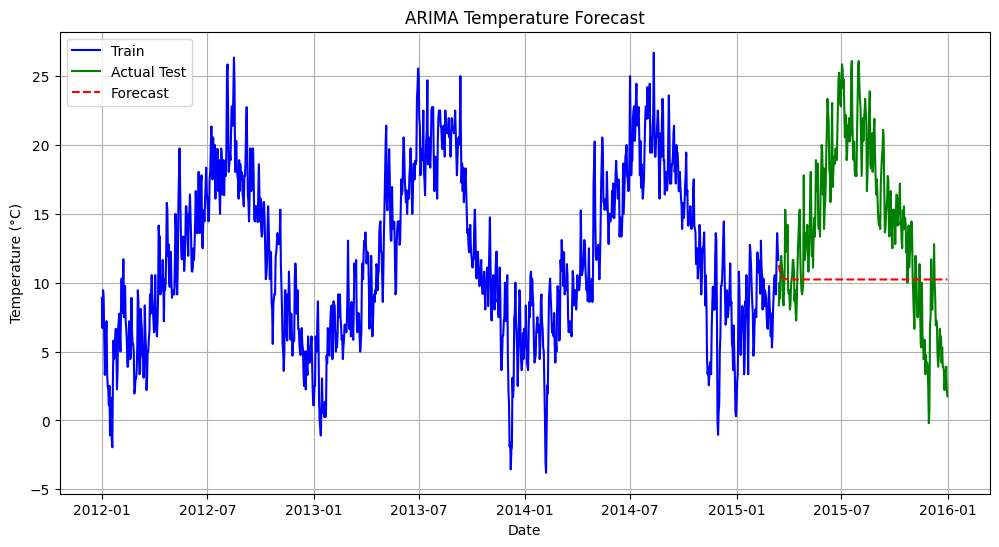

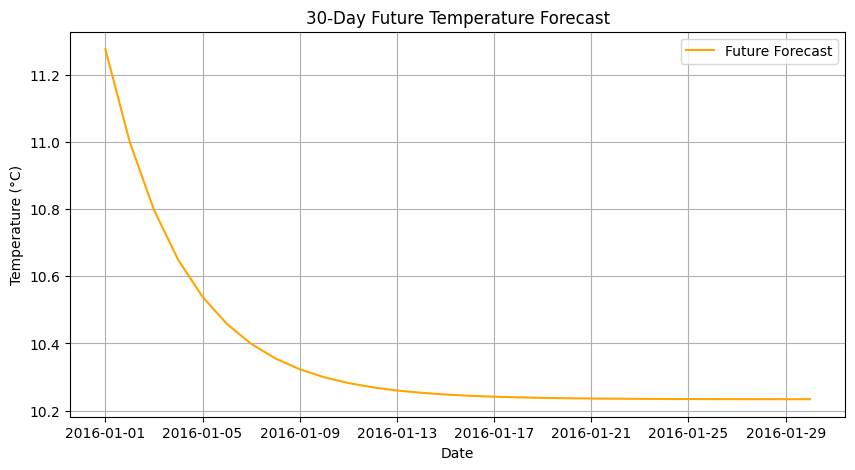

In [7]:
# Forecast for test period
forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps)

# Calculate RMSE
rmse = np.sqrt(np.mean((forecast - test)**2))
print(f'RMSE: {rmse:.2f}°C')

# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Actual Test', color='green')
plt.plot(test.index, forecast, label='Forecast', color='red', linestyle='--')
plt.title('ARIMA Temperature Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

# Forecast next 30 days
future_forecast = model_fit.forecast(steps=30)
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
plt.figure(figsize=(10, 5))
plt.plot(future_dates, future_forecast, label='Future Forecast', color='orange')
plt.title('30-Day Future Temperature Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()